# https://github.com/MorvanZhou/pytorch-A3C/tree/master

In [6]:
import pandas as pd
import utils

TS = 48 # Time steps

data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [1], TS)
data_test = data_test[0]


(17520, 2)


In [7]:
from a3c_worker_scss import A3C 
import torch
import torch.nn.functional as F
import numpy as np

capacity = 50.
MPATH = '__pycache__/a3c_gnet.pt'
N_S = 7
N_A = 2
gnet = A3C(N_S, N_A)
gnet.share_memory() 
opt = torch.optim.Adam(gnet.parameters(), lr=1e-4)
gnet.load_state_dict(torch.load(MPATH, weights_only=True))

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])
env = utils.ENV_BATT(data_test, capacity)
MAX_EP = data_test.shape[0]

with torch.no_grad():
    state = env.reset()
    for i in range(MAX_EP):
        _, logits = gnet.forward(state)
        action = torch.argmax(logits.unsqueeze(0), dim=1).numpy()[0]
        new_state, reward, done = env.step(action)
        print(logits, action)

        st = np.concatenate((new_state, np.array([action-1, reward.squeeze(0)])))
        df_out.loc[i] = st    
        state = new_state
            

tensor([0.4142, 0.5858]) 1
tensor([0.3838, 0.6162]) 1
tensor([0.3865, 0.6135]) 1
tensor([0.3939, 0.6061]) 1
tensor([0.3960, 0.6040]) 1
tensor([0.3941, 0.6059]) 1
tensor([0.3936, 0.6064]) 1
tensor([0.3694, 0.6306]) 1
tensor([0.3914, 0.6086]) 1
tensor([0.4123, 0.5877]) 1
tensor([0.4104, 0.5896]) 1
tensor([0.3918, 0.6082]) 1
tensor([0.4042, 0.5958]) 1
tensor([0.4131, 0.5869]) 1
tensor([0.4116, 0.5884]) 1
tensor([0.4131, 0.5869]) 1
tensor([0.4092, 0.5908]) 1
tensor([0.4074, 0.5926]) 1
tensor([0.4135, 0.5865]) 1
tensor([0.4110, 0.5890]) 1
tensor([0.4060, 0.5940]) 1
tensor([0.3913, 0.6087]) 1
tensor([0.3901, 0.6099]) 1
tensor([0.3716, 0.6284]) 1
tensor([0.3676, 0.6324]) 1
tensor([0.3569, 0.6431]) 1
tensor([0.3619, 0.6381]) 1
tensor([0.3403, 0.6597]) 1
tensor([0.3156, 0.6844]) 1
tensor([0.2971, 0.7029]) 1
tensor([0.2917, 0.7083]) 1
tensor([0.2818, 0.7182]) 1
tensor([0.2826, 0.7174]) 1
tensor([0.2844, 0.7156]) 1
tensor([0.2844, 0.7156]) 1
tensor([0.2845, 0.7155]) 1
tensor([0.2845, 0.7155]) 1
t

                      PV     LD         BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.855   5.000000  0.0  0.855  0.000000
2012-07-01 01:00:00  0.0  0.786   5.000000  0.0  0.786  0.000000
2012-07-01 01:30:00  0.0  0.604   5.000000  0.0  0.604  0.000000
2012-07-01 02:00:00  0.0  0.544   5.000000  0.0  0.544  0.000000
2012-07-01 02:30:00  0.0  0.597   5.000000  0.0  0.597  0.000000
...                  ...    ...        ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.414  28.120001  0.0  0.414  0.605581
2012-07-05 23:00:00  0.0  0.932  28.120001  0.0  0.932  0.606901
2012-07-05 23:30:00  0.0  0.070  28.120001  0.0  0.070  0.607580
2012-07-06 00:00:00  0.0  0.094  28.120001  0.0  0.094  0.608184
2012-07-06 00:30:00  0.0  0.056  28.120001  0.0  0.056  0.609626

[241 rows x 6 columns]


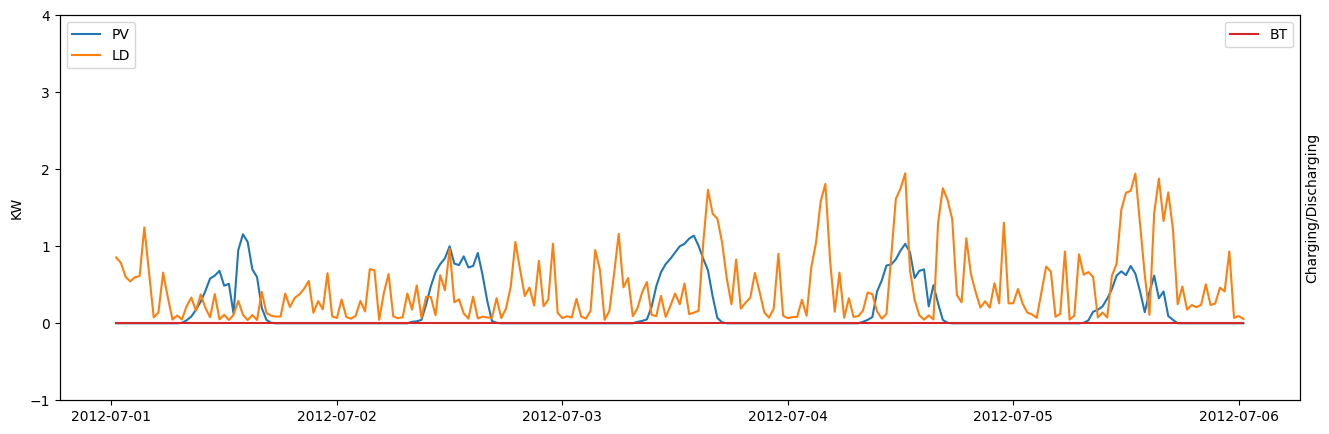

In [8]:
import matplotlib.pyplot as plt

start_pos = TS*0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
# ax1.plot(df_date.values, ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

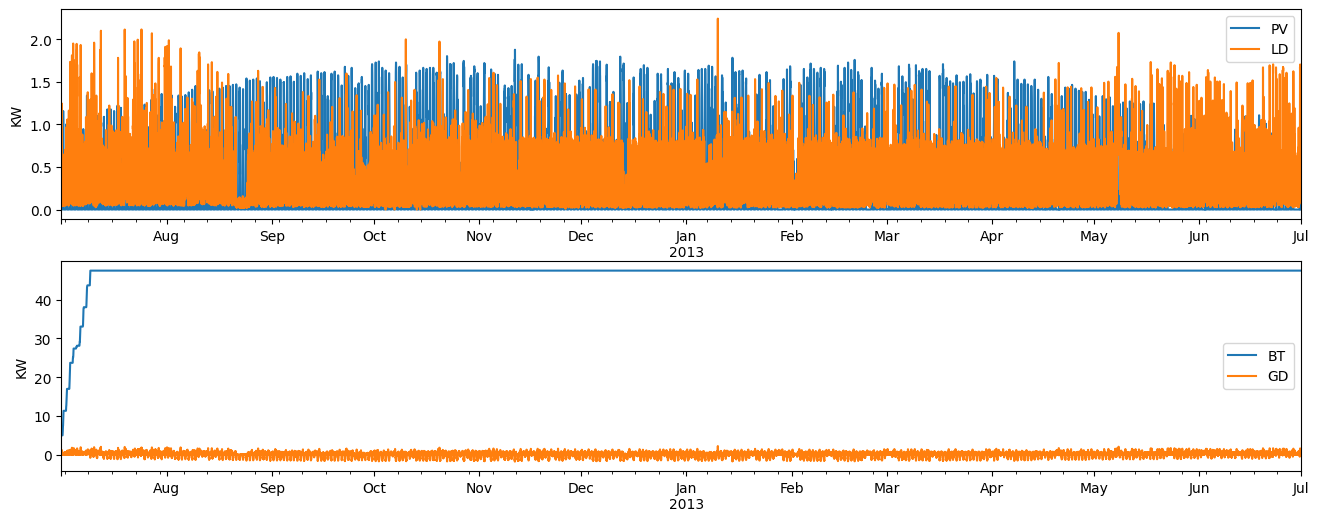

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [10]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

5115.207006187178 KW
5279.884002253413 KW
4021.2440011289436
-3814.0670004425338
SC : 0.2543670283863058
SS : 0.2464334453539752
